## Описание проекта

По датасету из вложения построить наилучший бинарный классификатор, целевой столбец – mark.

По стеку ограничений нет. 

## Загрузка библиотек

In [115]:
!pip install phik

   ---------------------------------------- 0.0/666.3 kB ? eta -:--:--
    --------------------------------------- 10.2/666.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/666.3 kB 325.1 kB/s eta 0:00:02
   --- ----------------------------------- 61.4/666.3 kB 465.5 kB/s eta 0:00:02
   -------- ----------------------------- 143.4/666.3 kB 853.3 kB/s eta 0:00:01
   ----------------- ---------------------- 286.7/666.3 kB 1.4 MB/s eta 0:00:01
   ------------------------------ --------- 501.8/666.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 666.3/666.3 kB 2.3 MB/s eta 0:00:00


In [131]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import plotly
from plotly.express import scatter

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.impute import SimpleImputer 

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from warnings import simplefilter

import shap
import phik

## Загрузка данных

In [2]:
data = pd.read_excel(r"C:\Users\shurf\Downloads\result_set.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ft 0    5000 non-null   float64
 1   Ft 1    5000 non-null   float64
 2   Ft 2    5000 non-null   float64
 3   Ft 3    5000 non-null   float64
 4   Ft 4    5000 non-null   float64
 5   Ft 5    5000 non-null   float64
 6   Ft 6    5000 non-null   float64
 7   Ft 7    5000 non-null   int64  
 8   Ft 8    5000 non-null   object 
 9   Ft 9    5000 non-null   object 
 10  Ft 10   4936 non-null   float64
 11  Ft 11   4950 non-null   object 
 12  Ft 12   5000 non-null   int64  
 13  Ft 13   5000 non-null   int64  
 14  Ft14    5000 non-null   int64  
 15  Ft15    4183 non-null   object 
 16  Ft16    5000 non-null   object 
 17  Ft17    5000 non-null   int64  
 18  mark    5000 non-null   int64  
dtypes: float64(8), int64(6), object(5)
memory usage: 742.3+ KB


In [4]:
data.head()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17,mark
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NaN,car,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1,0
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1,0
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NaN,radio/TV,1,0


В данных обнаружены пропуски, которые надо будет удалить. Также хочется привести названия столбцов к одному виду и поработать с типами данных.

## Предобработка данных

### Удаление пробелов и приведение к нижнему регистру 

In [5]:
data.columns = data.columns.str.replace(' ', '').str.lower()
data.columns

Index(['ft0', 'ft1', 'ft2', 'ft3', 'ft4', 'ft5', 'ft6', 'ft7', 'ft8', 'ft9',
       'ft10', 'ft11', 'ft12', 'ft13', 'ft14', 'ft15', 'ft16', 'ft17', 'mark'],
      dtype='object')

### Работа с пропусками

В таблице были замечены пропуски, есть несколько способов их устранения, в том числе заполнение среднем, заполнение модой и удаление в зависимости от природы данных. В большинстве столбцов утраченных данных не так много, поэтому думаю, что их можно смело удалить. Однако есть столбец data['ft15'] в котором процент пропусков почти 20%, не получится удалить все пропуски без сильного влияния на датасет. Поэтому заполню их еще одной категорией. Пропуски в остальных столбцах просуто удалю.

In [6]:
data['ft15'] = data['ft15'].fillna('No information')
data['ft15'].value_counts()

little            1505
moderate          1171
No information     817
quite rich         784
rich               723
Name: ft15, dtype: int64

In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4886 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ft0     4886 non-null   float64
 1   ft1     4886 non-null   float64
 2   ft2     4886 non-null   float64
 3   ft3     4886 non-null   float64
 4   ft4     4886 non-null   float64
 5   ft5     4886 non-null   float64
 6   ft6     4886 non-null   float64
 7   ft7     4886 non-null   int64  
 8   ft8     4886 non-null   object 
 9   ft9     4886 non-null   object 
 10  ft10    4886 non-null   float64
 11  ft11    4886 non-null   object 
 12  ft12    4886 non-null   int64  
 13  ft13    4886 non-null   int64  
 14  ft14    4886 non-null   int64  
 15  ft15    4886 non-null   object 
 16  ft16    4886 non-null   object 
 17  ft17    4886 non-null   int64  
 18  mark    4886 non-null   int64  
dtypes: float64(8), int64(6), object(5)
memory usage: 763.4+ KB


In [9]:
print('Потери данных составили:', 1 - 4886/5000, '%' )

Потери данных составили: 0.022800000000000042 %


## Исследовательский анализ данных

Теперь займемся исследованием данных. Проверим данные на выбросы и аномальные значения, а так проверим не ускальзнули от нас ли какие-либо ошибки в данных.

In [10]:
#Напишем пару функций для работы со столбцами

def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    
    
def categoral_unique(df, col):
    display(df[col].unique())
    
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)
    
    
def hist_with_wiskers(df, col):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Гистограмма для {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show()
    print(df[col].describe())

def pivot_bar_plot(df, col):
    plt.figure(figsize=(8,6))
    plot = sns.barplot(x=col, data=df, y=df.index)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

### ft0

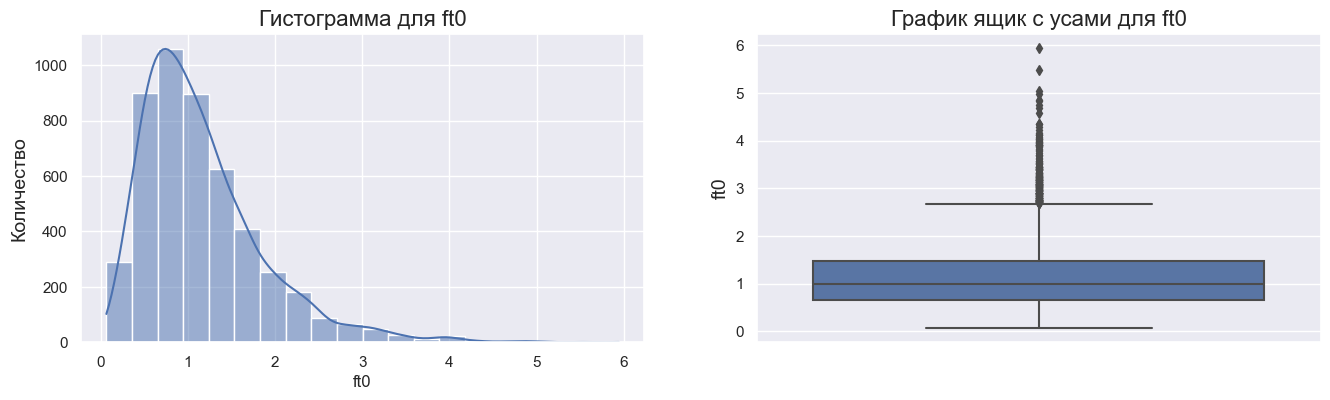

count    4886.000000
mean        1.156872
std         0.700266
min         0.066066
25%         0.660937
50%         1.000415
75%         1.471072
max         5.942049
Name: ft0, dtype: float64


In [11]:
hist_with_wiskers(data, 'ft0')

### ft1

In [12]:
data['ft1'].head()

0    1.056248
1    0.814288
2    1.607170
3    1.724393
4    1.748245
Name: ft1, dtype: float64

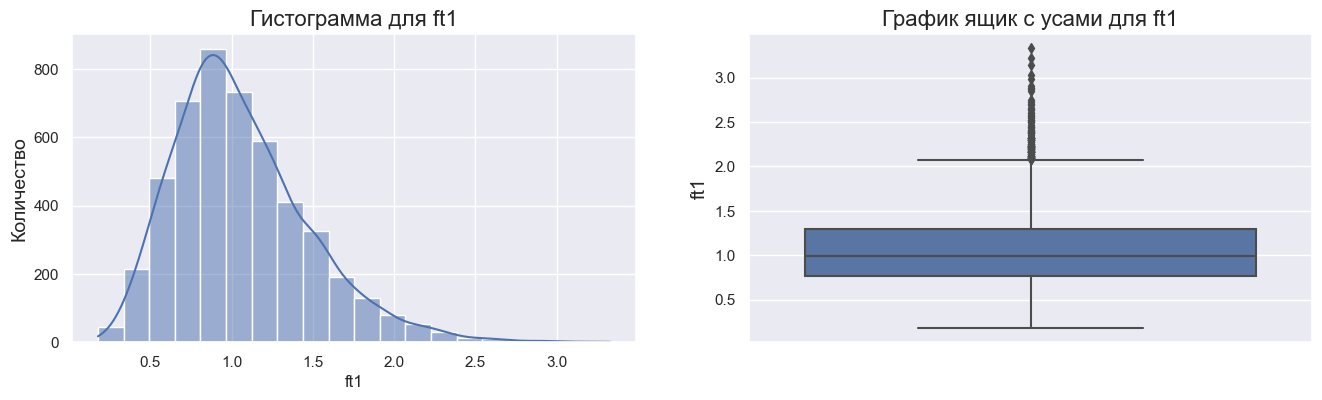

count    4886.000000
mean        1.059571
std         0.420152
min         0.177825
25%         0.765613
50%         0.992291
75%         1.291258
max         3.331410
Name: ft1, dtype: float64


In [13]:
hist_with_wiskers(data, 'ft1')

Тут распределение выглядит нормальным, выбросы присутсвуют, однако в ввиду того что нам неизвестна природа данных, в этом столбце буду их игнорировать

### ft2


In [14]:
data['ft2'].head()

0    0.114203
1    0.727210
2    0.479581
3    0.682358
4    1.045646
Name: ft2, dtype: float64

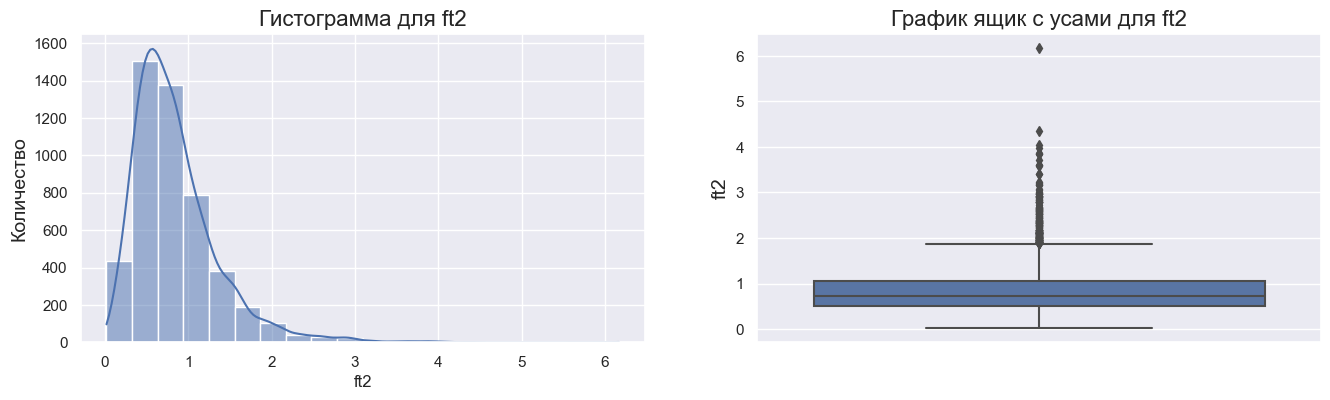

count    4886.000000
mean        0.840552
std         0.509172
min         0.017505
25%         0.498548
50%         0.732945
75%         1.051843
max         6.169126
Name: ft2, dtype: float64


In [15]:
hist_with_wiskers(data, 'ft2')

В данном случае есть ярко выраженные выбросы, которые подлежат удалению. Распределение выглядит нормальным.

In [16]:
data = data.query('ft2 < 4.1')

### ft3

In [17]:
data['ft3'].head()

0    6.175593
1    3.606359
2    3.521474
3    1.809472
4    1.560427
Name: ft3, dtype: float64

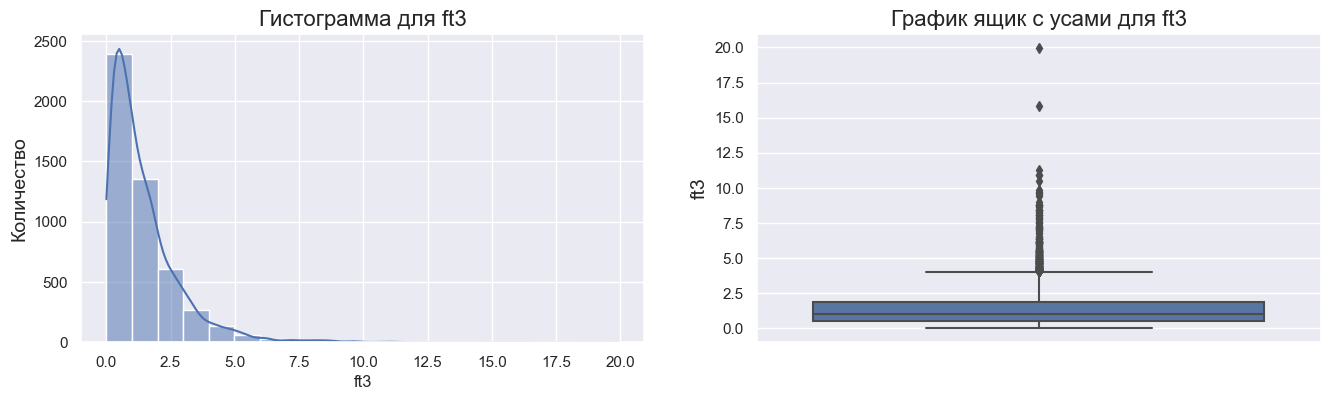

count    4884.000000
mean        1.433484
std         1.397246
min         0.001728
25%         0.482615
50%         1.029750
75%         1.904008
max        19.940927
Name: ft3, dtype: float64


In [18]:
hist_with_wiskers(data, 'ft3')

В данном случае есть ярко выраженные выбросы, которые подлежат удалению. Распределение выглядит нормальным.

In [19]:
data = data.query('ft2 < 10')

### ft4

In [20]:
data['ft4'].head()

0     5.625789
1     1.493780
2     1.663726
3    10.149721
4     1.269053
Name: ft4, dtype: float64

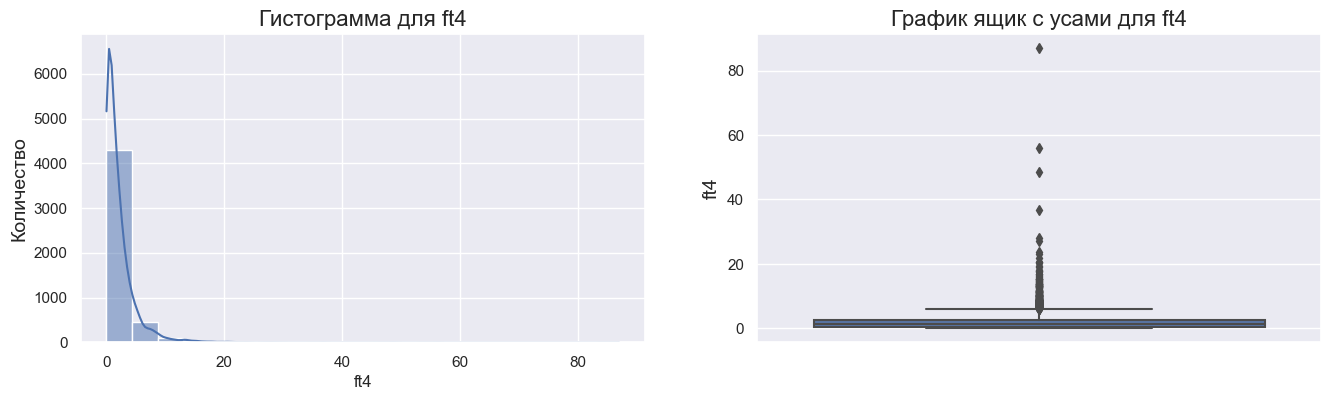

count    4884.000000
mean        2.073354
std         3.029901
min         0.000007
25%         0.404889
50%         1.247964
75%         2.668780
max        86.940693
Name: ft4, dtype: float64


In [21]:
hist_with_wiskers(data, 'ft4')

В данном случае есть ярко выраженные выбросы, которые подлежат удалению. Думаю тут можно удалить все что больше 20-ти, так как основная масса приходиться на промежуток <10. Распределение выглядит нормальным.

In [22]:
data = data.query('ft4 < 20')

### ft5

In [23]:
data['ft5'].head()

0    0.581535
1    7.810750
2    2.297903
3    2.999319
4    1.403952
Name: ft5, dtype: float64

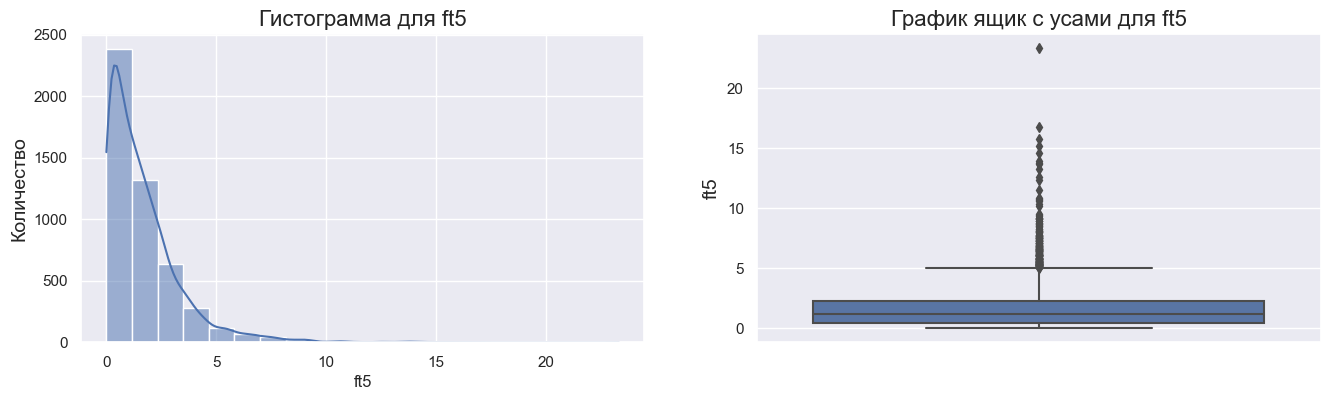

count    4872.000000
mean        1.661931
std         1.710468
min         0.002628
25%         0.467149
50%         1.201164
75%         2.290453
max        23.327828
Name: ft5, dtype: float64


In [24]:
hist_with_wiskers(data, 'ft5')

В данном случае есть ярко выраженные выбросы, которые подлежат удалению. Удалим выбросы больше 15-ти Распределение выглядит нормальным.

In [25]:
data = data.query('ft5 < 15')

### ft6

In [26]:
data['ft6'].head()

0     7.360085
1    20.314335
2    12.839282
3    49.108530
4     5.270951
Name: ft6, dtype: float64

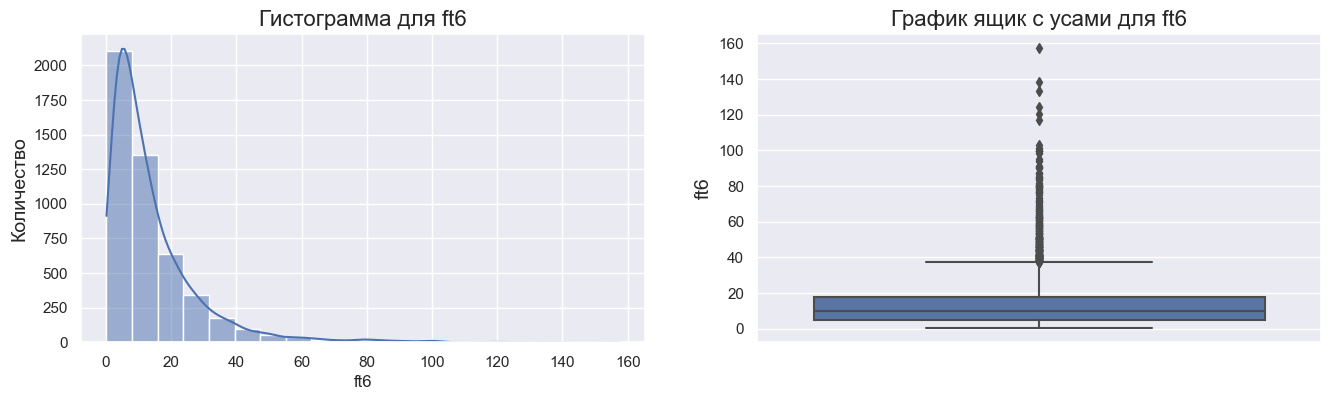

count    4868.000000
mean       13.997642
std        14.391523
min         0.190074
25%         4.819500
50%         9.610729
75%        17.884976
max       157.312632
Name: ft6, dtype: float64


In [27]:
hist_with_wiskers(data, 'ft6')

В данном случае есть ярко выраженные выбросы, которые подлежат удалению. Удалим выбросы больше 110-ти Распределение выглядит нормальным.

In [28]:
data = data.query('ft5 < 110')

### ft7

In [29]:
data['ft7'].head()

0    68
1    24
2    67
3    42
4    84
Name: ft7, dtype: int64

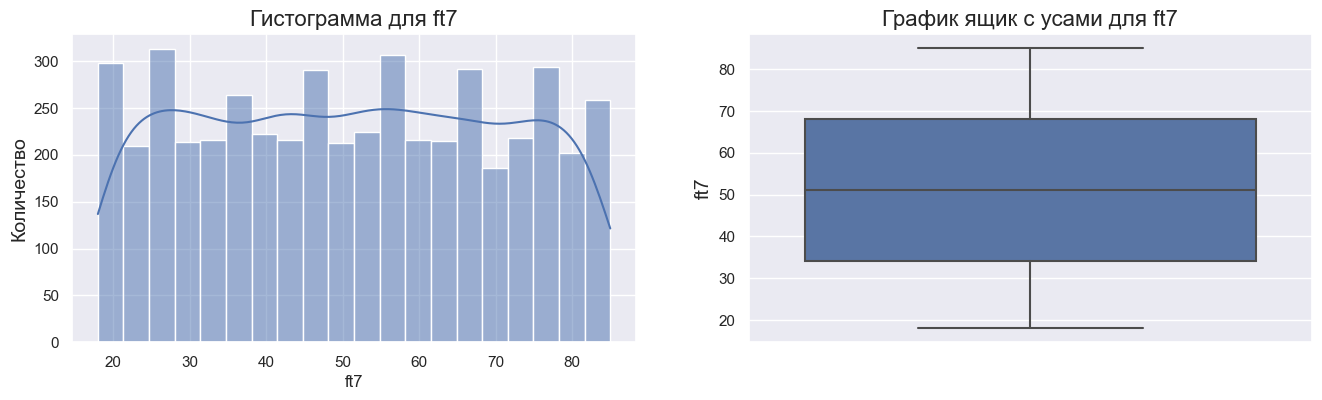

count    4868.000000
mean       51.095111
std        19.517716
min        18.000000
25%        34.000000
50%        51.000000
75%        68.000000
max        85.000000
Name: ft7, dtype: float64


In [30]:
hist_with_wiskers(data, 'ft7')

Распределение выглядит равномерным, что на моей практике говорит о синтетической природе происхождения данных. Такой параметр будет только сбивать модель, поэтому данный столбец подлежит удалению полностью.

In [31]:
data.drop('ft7', axis=1, inplace=True)

### ft8

In [32]:
data['ft8'].head()

0      male
1    female
2      male
3      male
4      male
Name: ft8, dtype: object

array(['male', 'female'], dtype=object)

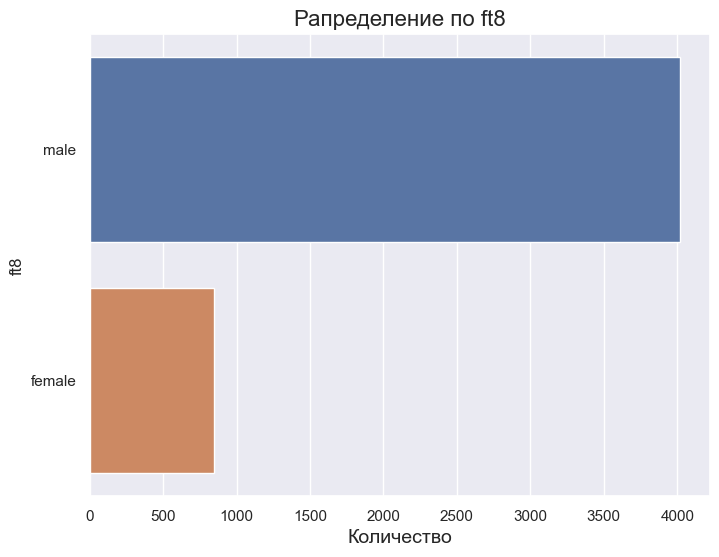

In [33]:
categoral_unique(data, 'ft8')

Видно что класса 'male' почти в 4 раза больше чем класса 'female'. В целом это может быть логичным ввиду природы данных, однако так как она нам не известна, то возможно придется бороться с дисбалансом классов

### ft9

In [34]:
data['ft9'].head()

0    very_low
1        high
2        high
3      medium
4    very_low
Name: ft9, dtype: object

array(['very_low', 'high', 'medium', 'low'], dtype=object)

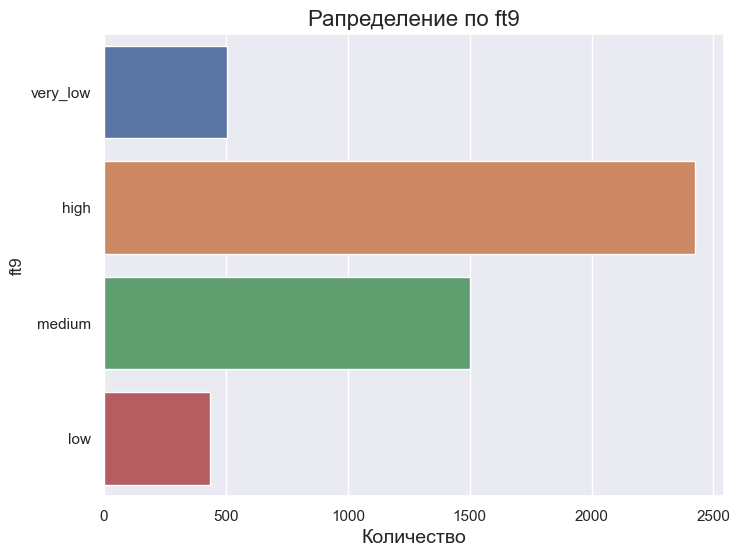

In [35]:
categoral_unique(data, 'ft9')

Кажется немного странным, что класса low меньше чем very_low. Возможно придется объединить эти классы в один

### ft10

In [36]:
data['ft10'].head()

0    535.0
1    846.0
2    782.0
3    132.0
4    708.0
Name: ft10, dtype: float64

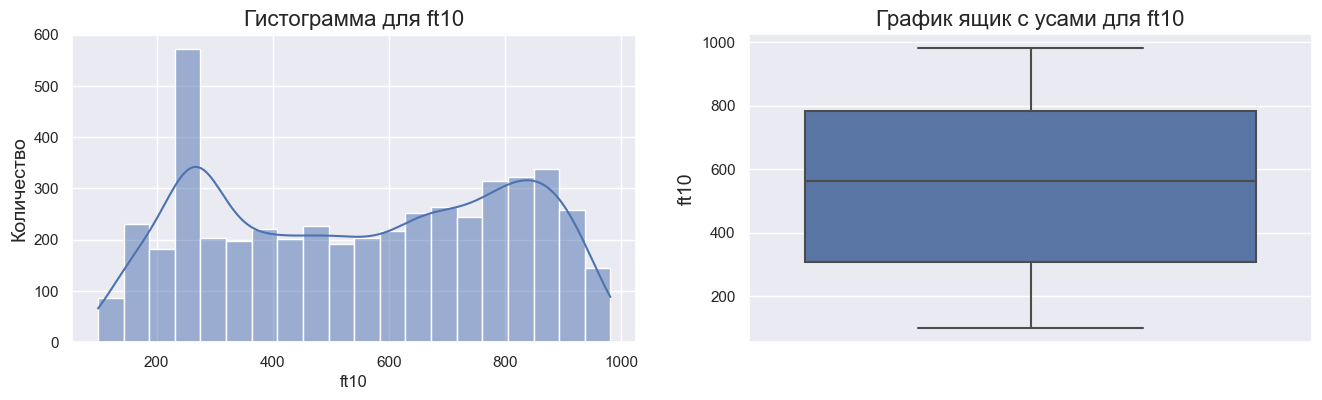

count    4868.000000
mean      553.504108
std       249.512241
min        99.000000
25%       309.000000
50%       563.000000
75%       784.000000
max       981.000000
Name: ft10, dtype: float64


In [37]:
hist_with_wiskers(data, 'ft10')

Распределение выглядит бимодальным с пиками в районе 250-ти и 900-та, выбросы отсутствуют. Держим этот признак в претендентах на удаление 

### ft11

In [38]:
data['ft11'].head()

0     True
1    False
2    False
3    False
4    False
Name: ft11, dtype: object

array([True, False], dtype=object)

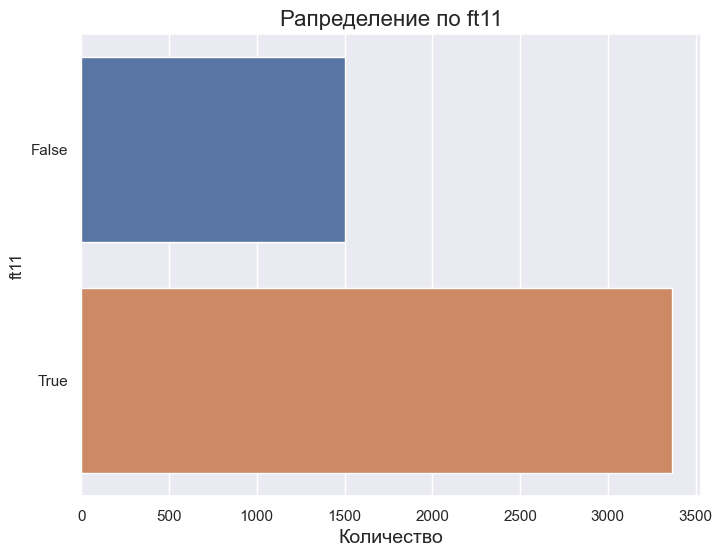

In [39]:
categoral_unique(data, 'ft11')

Тут все выглядит логичным

### ft12

In [40]:
data['ft12'].head()

0    5
1    3
2    0
3    3
4    0
Name: ft12, dtype: int64

array([    5,     3,     0,     2,     4,     1, -1000], dtype=int64)

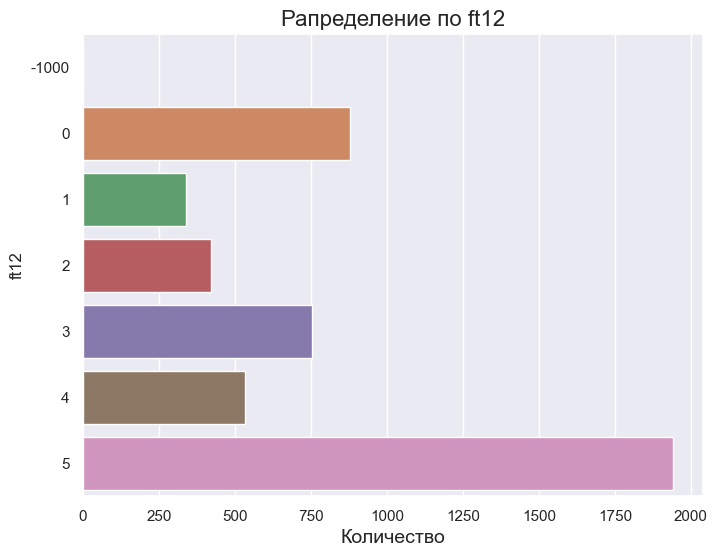

In [41]:
categoral_unique(data, 'ft12')

На лицо ошибка или выброс, необходимо удалить. В остальном все выглядит адекватным

In [42]:
data = data.query('ft12 > -1')

### ft13

In [43]:
data['ft13'].head()

0    5
1    1
2    0
3    3
4    0
Name: ft13, dtype: int64

array([5, 1, 0, 3, 2, 4], dtype=int64)

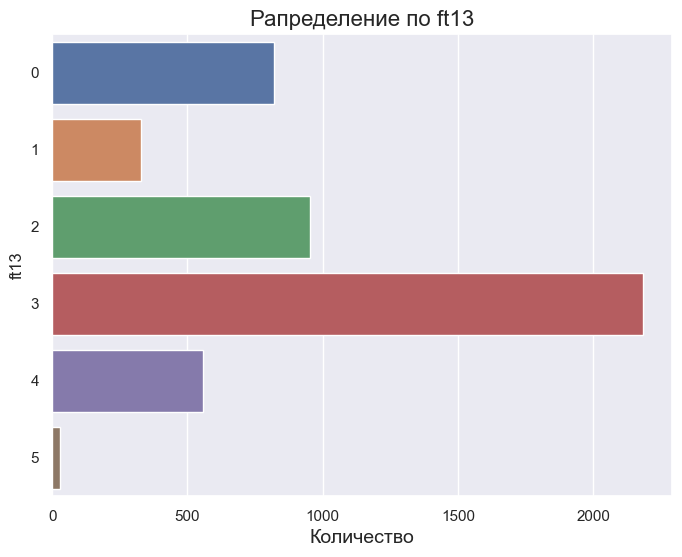

In [44]:
categoral_unique(data, 'ft13')

Заметно очень малое количество позиций в классе 5

### ft14

In [45]:
data['ft14'].head()

0    0
1    1
2    0
3    0
4    0
Name: ft14, dtype: int64

array([0, 1], dtype=int64)

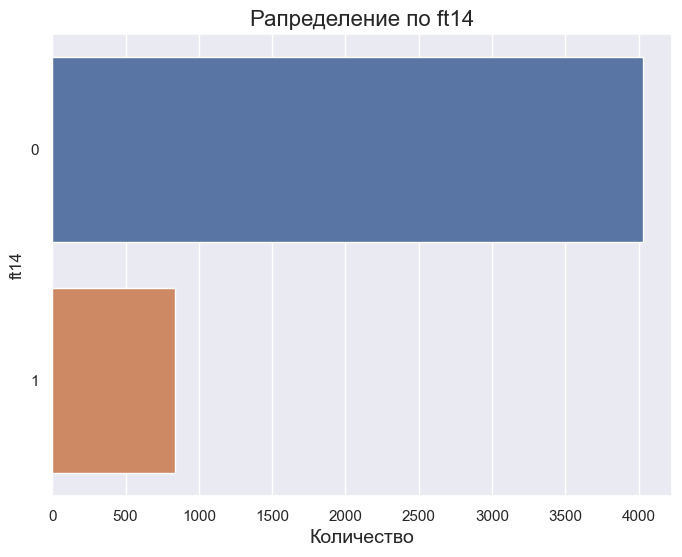

In [46]:
categoral_unique(data, 'ft14')

Столбец похож на столбец ft8, возможно они дублируют друг друга

In [47]:
data_check = data[['ft8', 'ft14']]
replacements = {'male': 0, 'female': '1'}
data_check['ft8'] =data_check['ft8'].map(replacements).fillna(data_check['ft8'])
data_check

C:\Users\shurf\AppData\Local\Temp\ipykernel_32776\4041753063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_check['ft8'] =data_check['ft8'].map(replacements).fillna(data_check['ft8'])


,ft8,ft14
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
4995,0,0
4996,0,0
4997,0,0
4998,1,0


In [48]:
data_check['ft8'].isin(data_check['ft14']).sum()

4017

In [49]:
data_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4866 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ft8     4866 non-null   object
 1   ft14    4866 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 243.1+ KB


In [61]:
print('Процент совпадений:',  4017/4866, '%' )

Процент совпадений: 0.8255240443896424 %


Эти столбцы не являются одинаковыми, как я предположил ранее, однако они все равно совпадают больше чем на 80 процентов. Подумаю что делать с той информацией

### ft15

In [51]:
data['ft15'].head()

0    No information
1        quite rich
2          moderate
3        quite rich
4    No information
Name: ft15, dtype: object

array(['No information', 'quite rich', 'moderate', 'rich', 'little'],
      dtype=object)

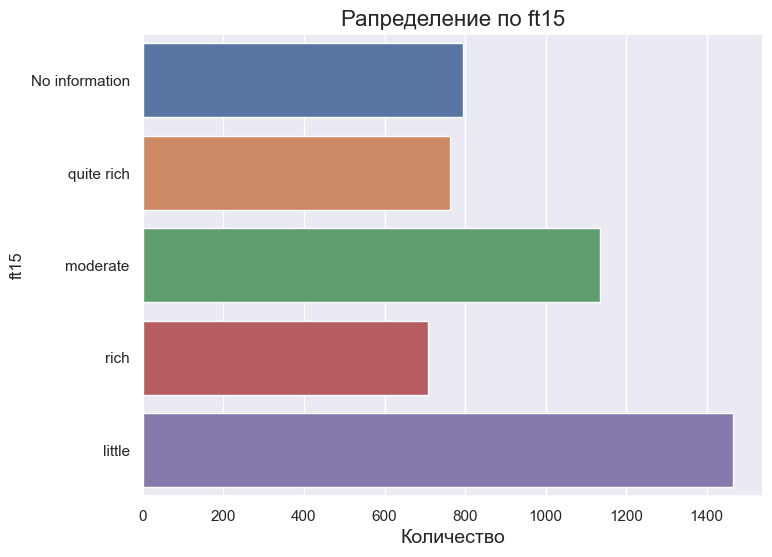

In [52]:
categoral_unique(data, 'ft15')

Напомню что в этом столбце класс No information то пропуски в таблице, и он занимает почти 20% данных, поэтому распределение в этом столбце нельзя считать до конца доставерным. Возможно этот столбец также придется вырезать

### ft16

In [53]:
data['ft16'].head()

0                    car
1                    car
2    furniture/equipment
3                    car
4               radio/TV
Name: ft16, dtype: object

array(['car', 'furniture/equipment', 'radio/TV', 'repairs', 'business',
       'education', 'domestic appliances', 'vacation/others'],
      dtype=object)

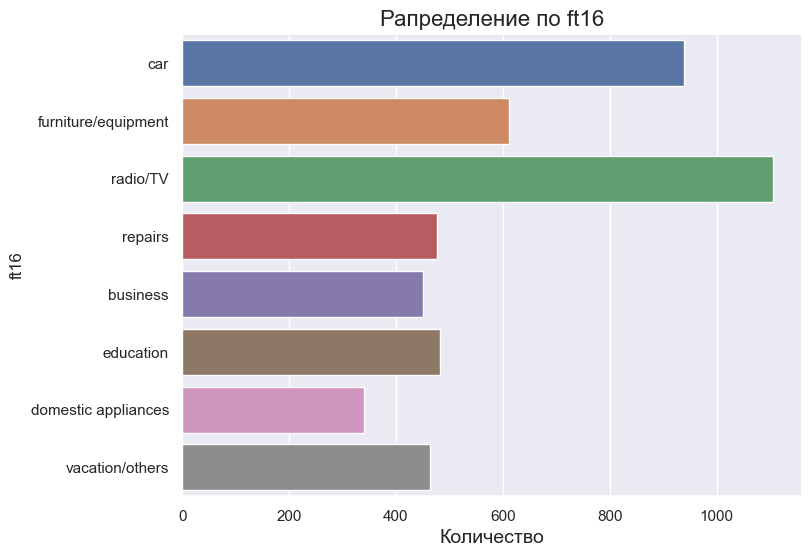

In [54]:
categoral_unique(data, 'ft16')

Никаких аномалий или прочих угроз тут я не вижу. заметно преобладание класса radio/TV над остальными

### ft17

In [55]:
data['ft17'].head()

0    0
1    1
2    1
3    0
4    1
Name: ft17, dtype: int64

array([0, 1], dtype=int64)

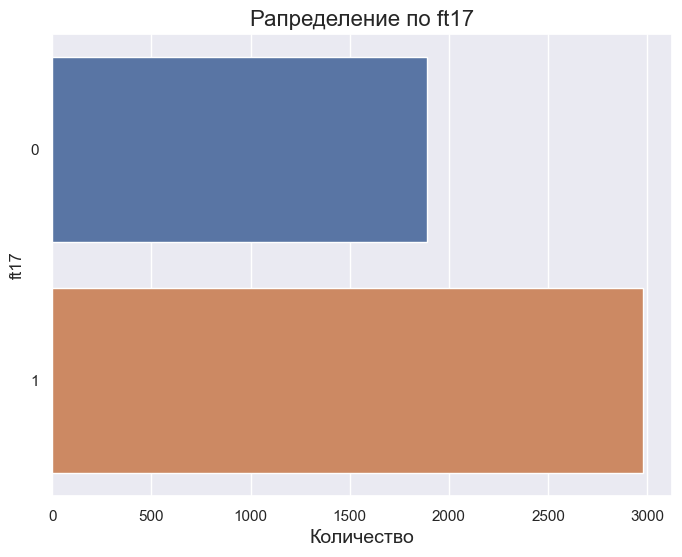

In [56]:
categoral_unique(data, 'ft17')

Никаких аномалий или прочих угроз тут я не вижу. Класс 1 преобладает над классом 0

### Целевой признак

Давайте также взглянем на распределение целевого признака

In [57]:
data['mark'].head()

0    0
1    0
2    0
3    0
4    0
Name: mark, dtype: int64

array([0, 1], dtype=int64)

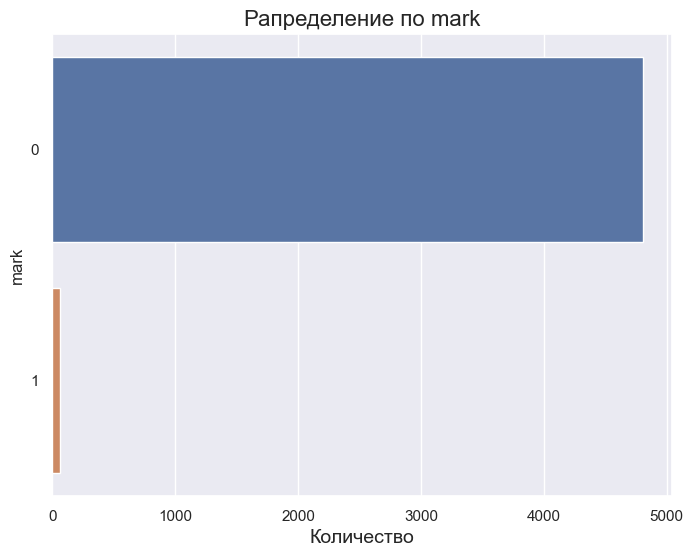

In [58]:
categoral_unique(data, 'mark')

Мда, на лицо явный дисбаланс классов, это может быть проблемой

### Вывод по Исследовательскому анализу данных.

Я посмотрел на все параметры таблицы включая целевой признак. У числовых столбцов были обработаны выбросы и распределения, для всех категориальных признаков были рассмотрены распределения классов.

Из интересного это удаление столбца ft7 в ввиду его распределение, схожесть признаков ft8 и ft14, а также заметный дисбаланс классов у целевого признака

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4866 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ft0     4866 non-null   float64
 1   ft1     4866 non-null   float64
 2   ft2     4866 non-null   float64
 3   ft3     4866 non-null   float64
 4   ft4     4866 non-null   float64
 5   ft5     4866 non-null   float64
 6   ft6     4866 non-null   float64
 7   ft8     4866 non-null   object 
 8   ft9     4866 non-null   object 
 9   ft10    4866 non-null   float64
 10  ft11    4866 non-null   object 
 11  ft12    4866 non-null   int64  
 12  ft13    4866 non-null   int64  
 13  ft14    4866 non-null   int64  
 14  ft15    4866 non-null   object 
 15  ft16    4866 non-null   object 
 16  ft17    4866 non-null   int64  
 17  mark    4866 non-null   int64  
dtypes: float64(8), int64(5), object(5)
memory usage: 851.3+ KB


In [60]:
print('Потери данных составили:', 1 - 4866/5000, '%' )

Потери данных составили: 0.026800000000000046 %


После удалений выбросов и аномалий потери данных составили меньше трех процентов что довольно хороший результат

## Корреляционный анализ

In [117]:
data.phik_matrix()

interval columns not set, guessing: ['ft0', 'ft1', 'ft2', 'ft3', 'ft4', 'ft5', 'ft6', 'ft10', 'ft12', 'ft13', 'ft14', 'ft17', 'mark']


,ft0,ft1,ft2,ft3,ft4,ft5,ft6,ft8,ft9,ft10,ft11,ft12,ft13,ft14,ft15,ft16,ft17,mark
ft0,1.000000,0.000000,0.039888,0.023358,0.000000,0.000000,0.000000,0.040450,0.000000,0.075644,0.000000,0.060346,0.000000,0.000000,0.000000,0.000000,0.000000,0.065254
ft1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024700,0.000000,0.000000,0.000000,0.033511,0.000000,0.000000,0.000000,0.000000,0.033334,0.000000
ft2,0.039888,0.000000,1.000000,0.226571,0.284693,0.170901,0.298298,0.254667,0.000000,0.067150,0.050845,0.052857,0.000000,0.000000,0.000000,0.018245,0.000000,0.081103
ft3,0.023358,0.000000,0.226571,1.000000,0.331612,0.217946,0.183896,0.159538,0.061660,0.000000,0.052869,0.000000,0.149361,0.010888,0.009990,0.000000,0.026265,0.057985
ft4,0.000000,0.000000,0.284693,0.331612,1.000000,0.432520,0.476671,0.344121,0.000000,0.029566,0.066556,0.038518,0.000000,0.000000,0.057756,0.037636,0.000000,0.000000
ft5,0.000000,0.000000,0.170901,0.217946,0.432520,1.000000,0.774296,0.489102,0.000000,0.000000,0.000000,0.033464,0.000000,0.018630,0.000000,0.029288,0.000000,0.087247
ft6,0.000000,0.000000,0.298298,0.183896,0.476671,0.774296,1.000000,0.887692,0.042076,0.000308,0.037665,0.033776,0.000000,0.056467,0.000000,0.026381,0.037362,0.000000
ft8,0.040450,0.024700,0.254667,0.159538,0.344121,0.489102,0.887692,1.000000,0.027348,0.015176,0.000000,0.038758,0.000000,0.156113,0.039390,0.000000,0.016264,0.000000
ft9,0.000000,0.000000,0.000000,0.061660,0.000000,0.000000,0.042076,0.027348,1.000000,0.034273,0.027904,0.025316,0.002086,0.000000,0.029069,0.000000,0.000000,0.035332
ft10,0.075644,0.000000,0.067150,0.000000,0.029566,0.000000,0.000308,0.015176,0.034273,1.000000,0.085244,0.052291,0.046366,0.418767,0.060799,0.041320,0.154026,0.070580


Как видно из таблицы, с целевым поле практически никто не коррелирует самая сильная коррелияция с полем ft14

## Пайплайны

In [66]:
#Разделяем данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['mark'], axis=1),
    data['mark'],
    test_size = 0.25, 
    random_state = 42)

In [209]:
#Тестовые таргеты нам, как бы, неизвестны, поэтому кодируем обучающие, исходя из их распределения, а затем кодируем тестовые используя обученый Энкодер
encoder = LabelEncoder()
y_train_trans = encoder.fit_transform(y_train)
y_test_trans = encoder.transform(y_test)

In [181]:
#Разделим данные по типу столбца
ohe_columns = [ 
    'ft8', 
    'ft11', 
    'ft14', 
    'ft15', 
    'ft16', 
    'ft17', 'ft12',
             'ft13']  


num_columns = ['ft0', 
               'ft1', 
               'ft2', 
               'ft3', 
               'ft4', 
               'ft5', 
               'ft6', 
               'ft10'] 

ord_columns = ['ft9']

In [182]:
#формируем пайплайн
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                         categories=[
                    ['very_low', 'low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [183]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [184]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
) 

In [185]:
simplefilter(action='ignore', category=FutureWarning)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
#  {
#    'models': [DecisionTreeClassifier(random_state=42)],
#    'models__max_depth': range(2, 5),
#    'models__max_features': range(2, 5)
#},
    
   # словарь для модели KNeighborsClassifier() 
#    {
#       'models': [KNeighborsClassifier()],
#       'models__n_neighbors': range(2, 5) 
#   },
    # словарь для модели SVC()
    
        {
        'models': [SVC(probability=True, random_state=42)],
        'models__C': range(1, 20),
        'models__degree': range(1, 6) 
    },

    # словарь для модели LogisticRegression()
#    {
#        'models': [LogisticRegression(
#            random_state=42, 
#            solver='liblinear', 
#            penalty='l1'
#        )],
#        'models__C': range(1, 5)
#    }
]

randomized_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
#    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_trans)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['ft8', 'ft11', 'ft14',
                                                   'ft15', 'ft16', 'ft17',
                                                   'ft12', 'ft13']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['very_low',
 

In [186]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.4991617770326907


In [187]:
y_test.value_counts()

0    1193
1      24
Name: mark, dtype: int64

In [188]:
y_test_pred.sum()

2

In [189]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.823484213467449


## Shap

Посмотрим на лучшую модель 

In [190]:
pipe_best_model = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVC(C=15, degree=1, probability=True, kernel='linear', random_state=42))
    ]
) 

In [191]:
X_train_get = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test_get = pd.DataFrame(data_preprocessor.transform(X_test))

In [192]:
columns_names = (pipe_best_model['preprocessor'].transformers_[0][1].get_feature_names(ohe_columns)).tolist() + (ord_columns)+ (num_columns)

In [193]:
X_train_get.columns = [columns_names]
X_test_get.columns = [columns_names]

In [194]:
pipe_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['ft8', 'ft11', 'ft14',
                                                   'ft15', 'ft16', 'ft17',
                                                   'ft12', 'ft13']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['very_low',
                                 

In [195]:
pipe_best_model.named_steps['models'].fit(X_train_get, y_train_trans)

SVC(C=15, degree=1, kernel='linear', probability=True, random_state=42)

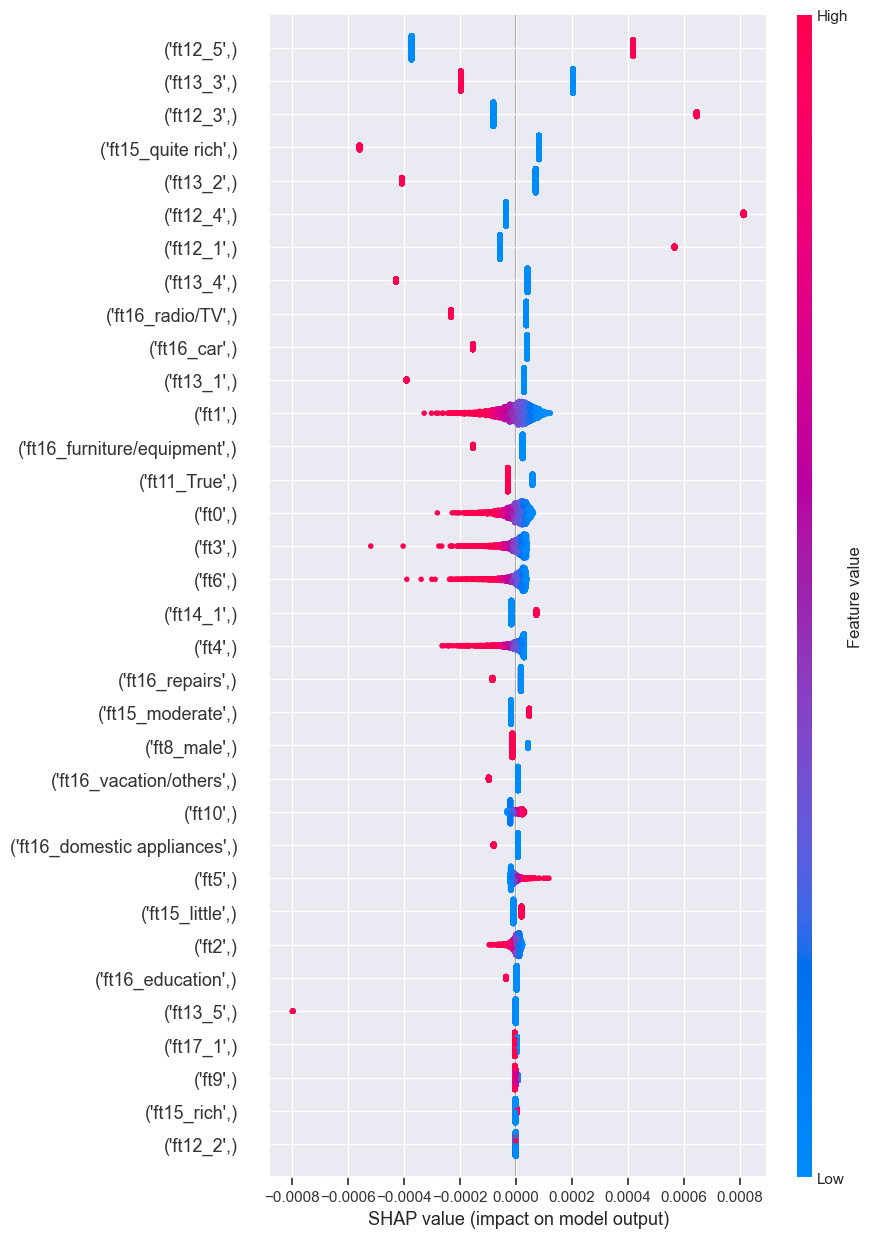

In [197]:
explainer = shap.LinearExplainer(pipe_best_model.named_steps['models'], X_train_get)
shap_values = explainer(X_train_get)

shap.plots.beeswarm(shap_values, max_display=35) 

Попробуем взять только 10 самых важных признаков

In [216]:
data_val = data[['ft12', 'ft13', 'ft15', 'ft16', 'ft1', 'ft11', 'ft0', 'ft3', 'ft6', 'mark']]

In [217]:
data_val

,ft12,ft13,ft15,ft16,ft1,ft11,ft0,ft3,ft6,mark
0,5,5,No information,car,1.056248,True,1.620967,6.175593,7.360085,0
1,3,1,quite rich,car,0.814288,False,1.274494,3.606359,20.314335,0
2,0,0,moderate,furniture/equipment,1.607170,False,0.569931,3.521474,12.839282,0
3,3,3,quite rich,car,1.724393,False,0.547560,1.809472,49.108530,0
4,0,0,No information,radio/TV,1.748245,False,1.798884,1.560427,5.270951,0
...,...,...,...,...,...,...,...,...,...,...
4995,4,3,No information,car,0.536588,False,0.559134,0.929000,3.664827,0
4996,2,2,moderate,domestic appliances,0.976926,True,1.857942,0.707998,10.778070,0
4997,5,3,little,domestic appliances,0.782006,True,1.207780,0.186188,16.717601,0
4998,5,3,little,radio/TV,1.191785,False,0.579599,1.139520,23.748920,0


In [230]:
#Разделяем данные на тренировочную и тестовую выборку
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
    data_val.drop(['mark'], axis=1),
    data_val['mark'],
    test_size = 0.25, 
    random_state = 42)

In [231]:
encoder_val = LabelEncoder()
y_train_val_trans = encoder_val.fit_transform(y_train_val)
y_test_val_trans = encoder_val.transform(y_test_val)

In [232]:
#Разделим данные по типу столбца
ohe_columns_val = [ 
    'ft11',  
    'ft15', 
    'ft16',  'ft12',
             'ft13']  


num_columns_val = ['ft0', 
               'ft1', 
               'ft3',  
               'ft6'] 

#ord_columns = ['ft9']

In [233]:
ohe_pipe_val = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                         categories=[
                    ['very_low', 'low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [234]:
data_preprocessor_val = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns_val),
        ('num', StandardScaler(), num_columns_val)
    ], 
    remainder='passthrough'
) 

In [235]:
pipe_final_val = Pipeline(
    [
        ('preprocessor', data_preprocessor_val),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
) 

In [238]:
simplefilter(action='ignore', category=FutureWarning)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
#  {
#    'models': [DecisionTreeClassifier(random_state=42)],
#    'models__max_depth': range(2, 5),
#    'models__max_features': range(2, 5)
#},
    
   # словарь для модели KNeighborsClassifier() 
#    {
#       'models': [KNeighborsClassifier()],
#       'models__n_neighbors': range(2, 5) 
#   },
    # словарь для модели SVC()
    
        {
        'models': [SVC(probability=True, random_state=42)],
        'models__C': range(1, 20),
        'models__degree': range(1, 6) 
    },

    # словарь для модели LogisticRegression()
#    {
#        'models': [LogisticRegression(
#            random_state=42, 
#            solver='liblinear', 
#            penalty='l1'
#        )],
#        'models__C': range(1, 5)
#    }
]

randomized_search = GridSearchCV(
    pipe_final_val, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
#    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train_val, y_train_val_trans)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['ft11', 'ft15', 'ft16',
                                                   'ft12', 'ft13']),
                                                 ('num', StandardScaler(),
                                                  ['ft0', 'ft1', 'ft3',
                                                   'ft6'])])),
                ('models',
                 SVC(C=16, degree=1, probability=True, random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.6755792557939947


In [239]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
y_test_pred = randomized_search.predict(X_test_val)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_val, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.5625


In [240]:
probabilities = randomized_search.predict_proba(X_test_val)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test_val, probabilities_one))

Площадь ROC-кривой: 0.7516415199776474
